<a href="https://colab.research.google.com/github/ADEGBOYEGA123/-ADEGBOYEGA123-.github.io/blob/main/Image_segementor_using_sigmoid_activation_for_output.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import warnings
warnings.filterwarnings(action='ignore')

In [2]:
image_width=128
image_height=128
image_channels=3

In [3]:
class DiceLoss(tf.keras.losses.Loss):
    def __init__(self, smooth=1e-6, gama=2):
        super(DiceLoss, self).__init__()
        self.name = 'NDL'
        self.smooth = smooth
        self.gama = gama

    def call(self, y_true, y_pred):
        y_true, y_pred = tf.cast(
            y_true, dtype=tf.float32), tf.cast(y_pred, tf.float32)
        nominator = 2 * \
            tf.reduce_sum(tf.multiply(y_pred, y_true)) + self.smooth
        denominator = tf.reduce_sum(
            y_pred ** self.gama) + tf.reduce_sum(y_true ** self.gama) + self.smooth
        result = 1 - tf.divide(nominator, denominator)
        return result

In [4]:
#Build model

#contractive path :
inputs=tf.keras.layers.Input((image_width,image_height,image_channels))

#input normalization
normalization=tf.keras.layers.Lambda(lambda x: x/255)(inputs)

#first convolution layer
conv1=tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same',strides=1)(normalization)
conv1_dropout=tf.keras.layers.Dropout(0.1)(conv1)
conv1_=tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(conv1_dropout)
conv1_maxpool=tf.keras.layers.MaxPooling2D((2,2),padding='same')(conv1_)

#second convolution layer
conv2=tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same',strides=1)(conv1_maxpool)
conv2_dropout=tf.keras.layers.Dropout(0.1)(conv2)
conv2_=tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(conv2_dropout)
conv2_maxpool=tf.keras.layers.MaxPooling2D((2,2))(conv2_)

#third convolution layer
conv3=tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(conv2_maxpool)
conv3_dropout=tf.keras.layers.Dropout(0.1)(conv3)
conv3_=tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='same')(conv3_dropout)
conv3_maxpool=tf.keras.layers.MaxPooling2D((2,2))(conv3_)

#fourth convolution layer
conv4=tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='SAME')(conv3_maxpool)
conv4_dropout=tf.keras.layers.Dropout(0.2)(conv4)
conv4_=tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='SAME')(conv4_dropout)
conv4_maxpool=tf.keras.layers.MaxPooling2D((2,2))(conv4_)

#fifth convolution layer
conv5=tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='SAME')(conv4_maxpool)
conv5_dropout=tf.keras.layers.Dropout(0.1)(conv5)
conv5_=tf.keras.layers.Conv2D(256,(3,3),activation='relu',kernel_initializer='he_normal',padding='SAME')(conv5_dropout)



#upsample: expansive path:

#sixth convolution layer
upsample6=tf.keras.layers.Conv2DTranspose(128,(2,2),strides=(2,2),padding='same')(conv5_)
upsample6_=tf.keras.layers.concatenate([upsample6,conv4_])
conv6=tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='SAME')(upsample6_)
conv6_dropout=tf.keras.layers.Dropout(0.2)(conv6)
conv6_=tf.keras.layers.Conv2D(128,(3,3),activation='relu',kernel_initializer='he_normal',padding='SAME')(conv6_dropout)

#seventh convolution layer
upsample7=tf.keras.layers.Conv2DTranspose(64,(2,2),strides=(2,2),padding='same')(conv6_)
upsample7_=tf.keras.layers.concatenate([upsample7,conv3_])
conv7=tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='SAME')(upsample7_)
conv7_dropout=tf.keras.layers.Dropout(0.2)(conv7)
conv7_=tf.keras.layers.Conv2D(64,(3,3),activation='relu',kernel_initializer='he_normal',padding='SAME')(conv7_dropout)

#eighth convolution layer
upsample8=tf.keras.layers.Conv2DTranspose(32,(2,2),strides=(2,2),padding='same')(conv7_)
upsample8_=tf.keras.layers.concatenate([upsample8,conv2_])
conv8=tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='SAME')(upsample8_)
conv8_dropout=tf.keras.layers.Dropout(0.1)(conv8)
conv8_=tf.keras.layers.Conv2D(32,(3,3),activation='relu',kernel_initializer='he_normal',padding='SAME')(conv8_dropout)

#ninth convolution layer
upsample9=tf.keras.layers.Conv2DTranspose(16,(2,2),strides=(2,2),padding='same')(conv8_)
upsample9_=tf.keras.layers.concatenate([upsample9,conv1_],axis=3)
conv9=tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='SAME')(upsample9_)
conv9_dropout=tf.keras.layers.Dropout(0.1)(conv9)
conv9_=tf.keras.layers.Conv2D(16,(3,3),activation='relu',kernel_initializer='he_normal',padding='SAME')(conv9_dropout)


outputs=tf.keras.layers.Conv2D(1,(1,1),activation='sigmoid')(conv9_)

model=tf.keras.Model(inputs=[inputs],outputs=[outputs])

early_stopping=tf.keras.callbacks.EarlyStopping(patience=5,restore_best_weights=True)

#tensor_board_logs=tf.keras.callbacks.TensorBoard(TensorAlgorithms.TensorBoardRunLog().log_directory())

model.compile(optimizer='adam',loss='BinaryCrossentropy',metrics=['accuracy'])

#model.summary()

In [5]:
dataset, info = tfds.load('oxford_iiit_pet', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating train examples...:   0%|          | 0/3680 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete0Y5UDJ/oxford_iiit_pet-train.tfrecord*...:…

Generating test examples...:   0%|          | 0/3669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete0Y5UDJ/oxford_iiit_pet-test.tfrecord*...: …

Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


In [6]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) /1
  input_mask -= 1
  return input_image, input_mask

In [7]:
def load_image(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(
    datapoint['segmentation_mask'],
    (128, 128),
    method = tf.image.ResizeMethod.NEAREST_NEIGHBOR,
  )

  input_image, input_mask = normalize(input_image, input_mask)

  return input_image, input_mask

In [8]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [9]:
train_images = dataset['train'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset['test'].map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [10]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)
  
  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

In [11]:
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

test_batches = test_images.batch(BATCH_SIZE)



In [12]:
import matplotlib.pyplot as plt
import numpy as np
def transform(dataset=None,BatchSize=64):  
  x,y=[],[]
  count=0
  for image,label in dataset.take(1):
    for image,label in zip(image,label):
      image=list(np.array(image).flatten())
      label=list(np.array(label).flatten())
      max_pixel_value=np.array(label).flatten()[np.argmax(np.array(label[0]).flatten())]

      def binarize_pixels(z):
        if z < max_pixel_value:
          z=1
        elif z>= max_pixel_value:
          z=0
        else:
          print('error')
        return z
      label=np.array(list(map(binarize_pixels,label))).reshape(128,128,1)
      y+=list(label.flatten())
      x+=image
      count+=1
  x,y=tf.cast(np.array(x).reshape(count,128,128,3),tf.float32),tf.cast(np.array(y).reshape(count,128,128,1),tf.float32)
  return x,y

x_train_data,x_train_label=transform(dataset=train_batches)

x_test_data,x_test_label=transform(dataset=test_batches)

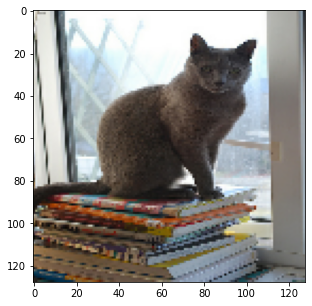

In [13]:
fig=plt.figure(1,figsize=(5,5))
ax=fig.add_subplot(1,1,1)
ax.imshow(tf.keras.utils.array_to_img(x_train_data[3]),cmap='gray')
plt.show()


In [14]:
import matplotlib.pyplot as plt
import PIL
import numpy as np
from google.colab import output
class DisplayCallback(tf.keras.callbacks.Callback):

  def __init__(self):

    self.__num_results=None
  
  def show_predictions(self):

    import matplotlib.pyplot as plt

    image=train_images.take(self.__num_results)
    
    titles=['Image','Expected mask','Predicted Mask']
    count=0
    for i in image:
      
      fig=plt.figure(1,figsize=(10,10))

      predictions=(np.array(model.predict(np.array(i[0]).reshape(1,128,128,3))).flatten()).reshape(128,128,1)

      for pos in range(len(i)):

        ax=fig.add_subplot(1,4,pos+1)
        
        ax.imshow(tf.keras.utils.array_to_img(i[pos]))
      
      ax=fig.add_subplot(1,4,pos+2)
      
      ax.imshow(tf.keras.utils.array_to_img(np.array(x_train_label)[count]),cmap='gray')
      
      ax=fig.add_subplot(1,4,pos+3)
      
      ax.imshow(tf.keras.utils.array_to_img(predictions),cmap='gray')
      count+=1

    plt.show()
    
    #output.clear(wait=True)

  def on_epoch_end(self, epoch, logs=None,num_results=1):

    self.__num_results=num_results

    self.show_predictions()
  
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))
    print('.....................................................')



Epoch 1/100
1/1 [==============================] - 0s 21ms/step


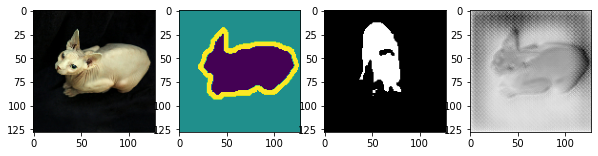


Sample Prediction after epoch 1

.....................................................
1/1 [==============================] - 7s 7s/step - loss: 0.6202 - accuracy: 0.6747 - val_loss: 0.6007 - val_accuracy: 0.6942
Epoch 2/100
1/1 [==============================] - 0s 22ms/step


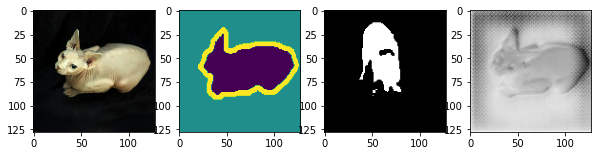


Sample Prediction after epoch 2

.....................................................
1/1 [==============================] - 1s 820ms/step - loss: 0.6022 - accuracy: 0.6748 - val_loss: 0.6038 - val_accuracy: 0.6942
Epoch 3/100
1/1 [==============================] - 0s 22ms/step


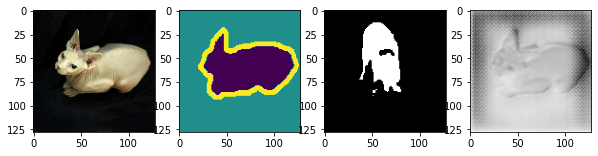


Sample Prediction after epoch 3

.....................................................
1/1 [==============================] - 1s 761ms/step - loss: 0.5991 - accuracy: 0.6748 - val_loss: 0.5910 - val_accuracy: 0.6942
Epoch 4/100
1/1 [==============================] - 0s 35ms/step


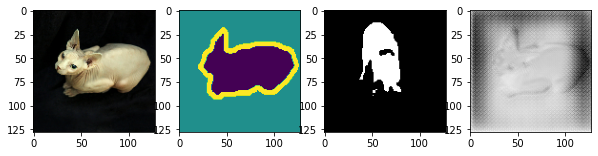


Sample Prediction after epoch 4

.....................................................
1/1 [==============================] - 1s 1s/step - loss: 0.5900 - accuracy: 0.6748 - val_loss: 0.5666 - val_accuracy: 0.6942
Epoch 5/100
1/1 [==============================] - 0s 33ms/step


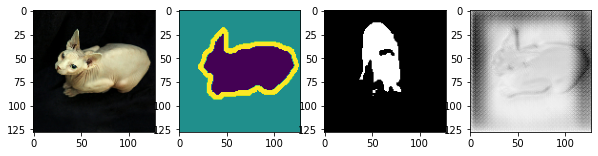


Sample Prediction after epoch 5

.....................................................
1/1 [==============================] - 1s 1s/step - loss: 0.5901 - accuracy: 0.6747 - val_loss: 0.5844 - val_accuracy: 0.6942
Epoch 6/100
1/1 [==============================] - 0s 23ms/step


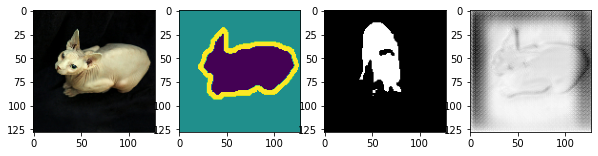


Sample Prediction after epoch 6

.....................................................
1/1 [==============================] - 1s 755ms/step - loss: 0.5815 - accuracy: 0.6748 - val_loss: 0.5905 - val_accuracy: 0.6942
Epoch 7/100
1/1 [==============================] - 0s 21ms/step


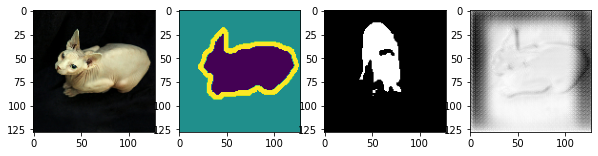


Sample Prediction after epoch 7

.....................................................
1/1 [==============================] - 1s 737ms/step - loss: 0.5819 - accuracy: 0.6748 - val_loss: 0.5789 - val_accuracy: 0.6942
Epoch 8/100
1/1 [==============================] - 0s 22ms/step


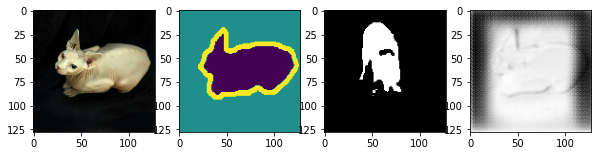


Sample Prediction after epoch 8

.....................................................
1/1 [==============================] - 1s 762ms/step - loss: 0.5754 - accuracy: 0.6749 - val_loss: 0.5564 - val_accuracy: 0.6942
Epoch 9/100
1/1 [==============================] - 0s 25ms/step


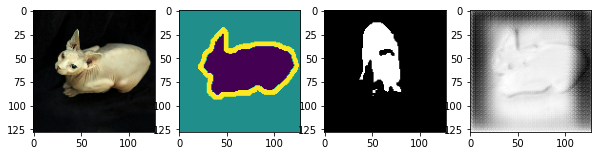


Sample Prediction after epoch 9

.....................................................
1/1 [==============================] - 1s 801ms/step - loss: 0.5766 - accuracy: 0.6749 - val_loss: 0.5650 - val_accuracy: 0.6942
Epoch 10/100
1/1 [==============================] - 0s 23ms/step


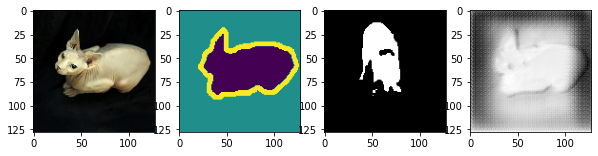


Sample Prediction after epoch 10

.....................................................
1/1 [==============================] - 1s 764ms/step - loss: 0.5645 - accuracy: 0.6749 - val_loss: 0.5719 - val_accuracy: 0.6942
Epoch 11/100
1/1 [==============================] - 0s 22ms/step


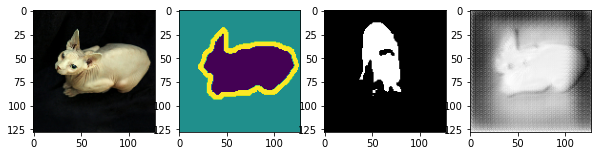


Sample Prediction after epoch 11

.....................................................
1/1 [==============================] - 1s 728ms/step - loss: 0.5630 - accuracy: 0.6750 - val_loss: 0.5656 - val_accuracy: 0.6942
Epoch 12/100
1/1 [==============================] - 0s 22ms/step


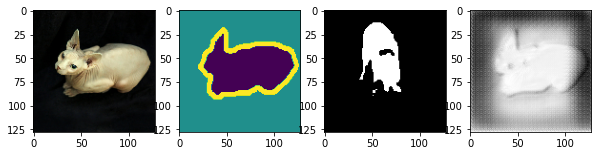


Sample Prediction after epoch 12

.....................................................
1/1 [==============================] - 1s 755ms/step - loss: 0.5598 - accuracy: 0.6750 - val_loss: 0.5591 - val_accuracy: 0.6942
Epoch 13/100
1/1 [==============================] - 0s 21ms/step


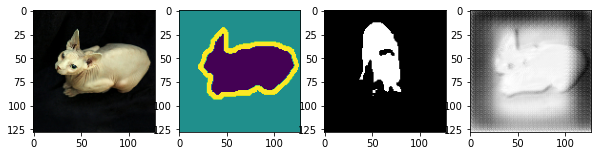


Sample Prediction after epoch 13

.....................................................
1/1 [==============================] - 1s 782ms/step - loss: 0.5524 - accuracy: 0.6750 - val_loss: 0.5474 - val_accuracy: 0.6942
Epoch 14/100
1/1 [==============================] - 0s 23ms/step


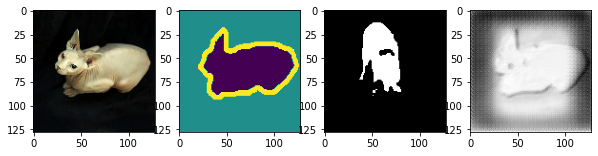


Sample Prediction after epoch 14

.....................................................
1/1 [==============================] - 1s 1s/step - loss: 0.5495 - accuracy: 0.6750 - val_loss: 0.5550 - val_accuracy: 0.6942
Epoch 15/100
1/1 [==============================] - 0s 22ms/step


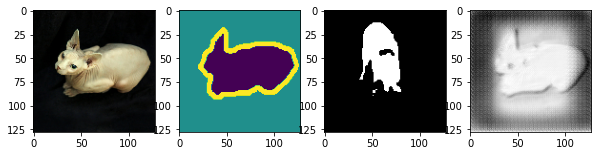


Sample Prediction after epoch 15

.....................................................
1/1 [==============================] - 1s 776ms/step - loss: 0.5450 - accuracy: 0.6750 - val_loss: 0.5539 - val_accuracy: 0.6942
Epoch 16/100
1/1 [==============================] - 0s 26ms/step


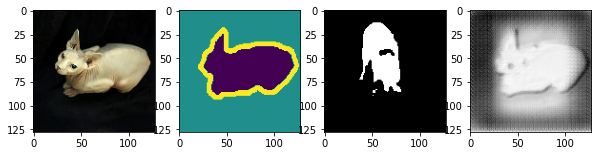


Sample Prediction after epoch 16

.....................................................
1/1 [==============================] - 1s 776ms/step - loss: 0.5414 - accuracy: 0.6751 - val_loss: 0.5495 - val_accuracy: 0.6942
Epoch 17/100
1/1 [==============================] - 0s 25ms/step


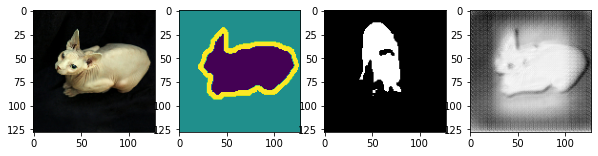


Sample Prediction after epoch 17

.....................................................
1/1 [==============================] - 1s 753ms/step - loss: 0.5382 - accuracy: 0.6751 - val_loss: 0.5630 - val_accuracy: 0.6942
Epoch 18/100
1/1 [==============================] - 0s 41ms/step


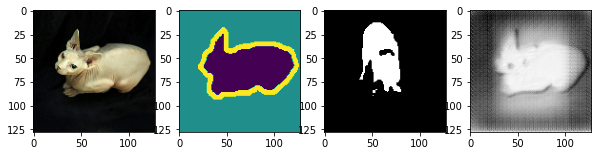


Sample Prediction after epoch 18

.....................................................
1/1 [==============================] - 1s 1s/step - loss: 0.5365 - accuracy: 0.6752 - val_loss: 0.5423 - val_accuracy: 0.6943
Epoch 19/100
1/1 [==============================] - 0s 32ms/step


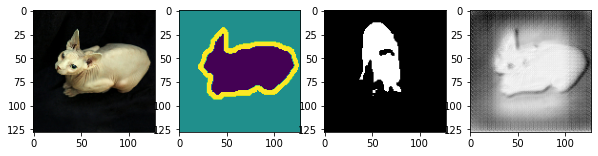


Sample Prediction after epoch 19

.....................................................
1/1 [==============================] - 1s 1s/step - loss: 0.5347 - accuracy: 0.6753 - val_loss: 0.5769 - val_accuracy: 0.6944
Epoch 20/100
1/1 [==============================] - 0s 22ms/step


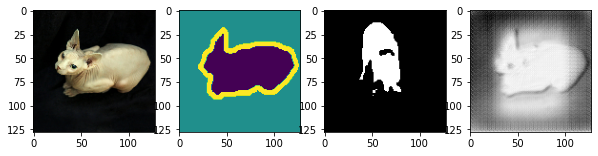


Sample Prediction after epoch 20

.....................................................
1/1 [==============================] - 1s 761ms/step - loss: 0.5420 - accuracy: 0.6762 - val_loss: 0.5491 - val_accuracy: 0.6947
Epoch 21/100
1/1 [==============================] - 0s 21ms/step


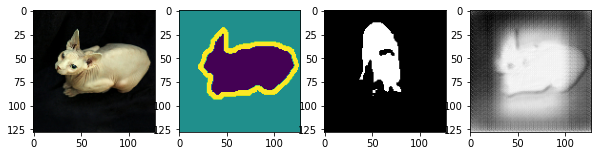


Sample Prediction after epoch 21

.....................................................
1/1 [==============================] - 1s 790ms/step - loss: 0.5262 - accuracy: 0.6769 - val_loss: 0.5217 - val_accuracy: 0.6951
Epoch 22/100
1/1 [==============================] - 0s 23ms/step


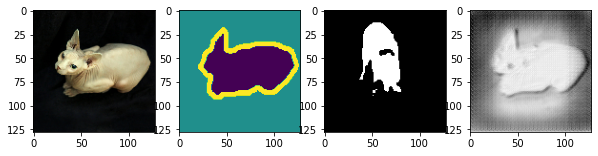


Sample Prediction after epoch 22

.....................................................
1/1 [==============================] - 1s 757ms/step - loss: 0.5515 - accuracy: 0.6775 - val_loss: 0.5982 - val_accuracy: 0.6967
Epoch 23/100
1/1 [==============================] - 0s 21ms/step


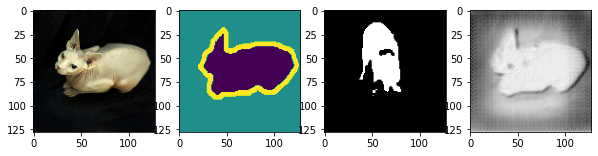


Sample Prediction after epoch 23

.....................................................
1/1 [==============================] - 1s 767ms/step - loss: 0.5664 - accuracy: 0.6786 - val_loss: 0.6122 - val_accuracy: 0.6973
Epoch 24/100
1/1 [==============================] - 0s 21ms/step


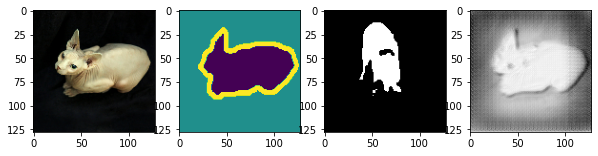


Sample Prediction after epoch 24

.....................................................
1/1 [==============================] - 1s 726ms/step - loss: 0.5868 - accuracy: 0.6791 - val_loss: 0.5921 - val_accuracy: 0.6972
Epoch 25/100
1/1 [==============================] - 0s 22ms/step


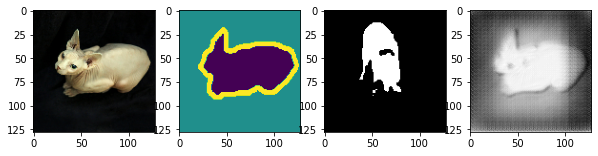


Sample Prediction after epoch 25

.....................................................
1/1 [==============================] - 1s 899ms/step - loss: 0.5607 - accuracy: 0.6798 - val_loss: 0.5388 - val_accuracy: 0.6960
Epoch 26/100
1/1 [==============================] - 0s 21ms/step


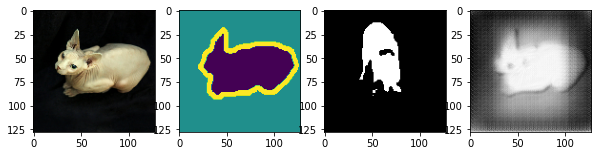


Sample Prediction after epoch 26

.....................................................
1/1 [==============================] - 1s 769ms/step - loss: 0.5310 - accuracy: 0.6789 - val_loss: 0.5130 - val_accuracy: 0.6959
Epoch 27/100
1/1 [==============================] - 0s 24ms/step


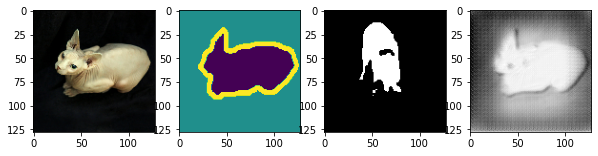


Sample Prediction after epoch 27

.....................................................
1/1 [==============================] - 1s 735ms/step - loss: 0.5601 - accuracy: 0.6784 - val_loss: 0.5554 - val_accuracy: 0.6988
Epoch 28/100
1/1 [==============================] - 0s 23ms/step


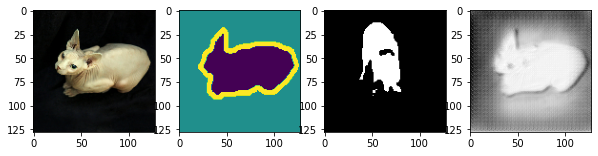


Sample Prediction after epoch 28

.....................................................
1/1 [==============================] - 1s 748ms/step - loss: 0.5227 - accuracy: 0.6818 - val_loss: 0.5785 - val_accuracy: 0.7018
Epoch 29/100
1/1 [==============================] - 0s 24ms/step


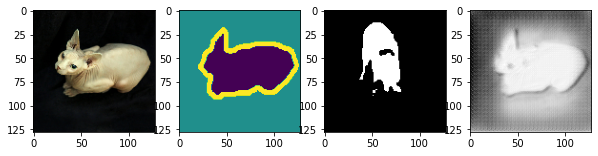


Sample Prediction after epoch 29

.....................................................
1/1 [==============================] - 1s 1s/step - loss: 0.5450 - accuracy: 0.6836 - val_loss: 0.5717 - val_accuracy: 0.7034
Epoch 30/100
1/1 [==============================] - 0s 26ms/step


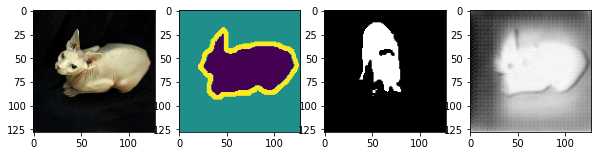


Sample Prediction after epoch 30

.....................................................
1/1 [==============================] - 1s 767ms/step - loss: 0.5430 - accuracy: 0.6842 - val_loss: 0.5417 - val_accuracy: 0.7029
Epoch 31/100
1/1 [==============================] - 0s 22ms/step


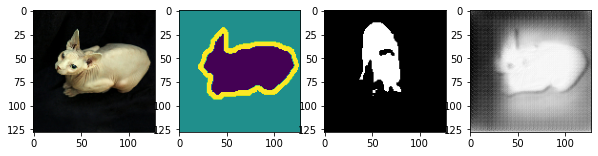


Sample Prediction after epoch 31

.....................................................
1/1 [==============================] - 1s 832ms/step - loss: 0.5285 - accuracy: 0.6838 - val_loss: 0.5177 - val_accuracy: 0.7019


In [20]:
np.random.seed(45)
history=model.fit(x_train_data,x_train_label,validation_data=(x_test_data,x_test_label),epochs=100,steps_per_epoch=1,validation_steps=1,callbacks=[DisplayCallback(),early_stopping])

In [16]:
import os
model.save('first_image_segementor.h5')

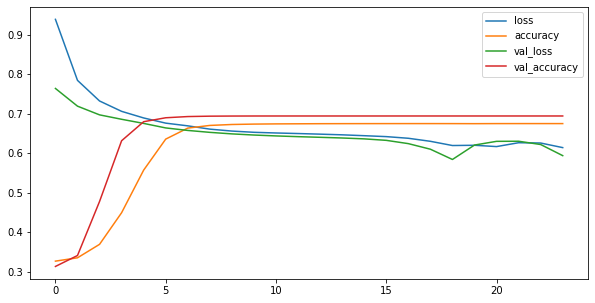

In [17]:
import pandas as pd
history_data=pd.DataFrame(history.history).plot(figsize=(10,5))

1/1 [==============================] - 0s 252ms/step


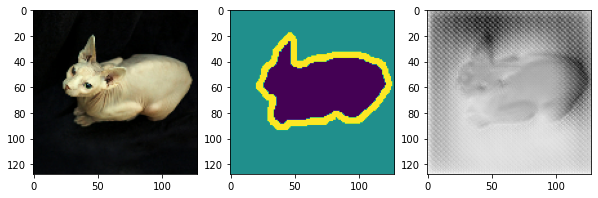

1/1 [==============================] - 0s 22ms/step


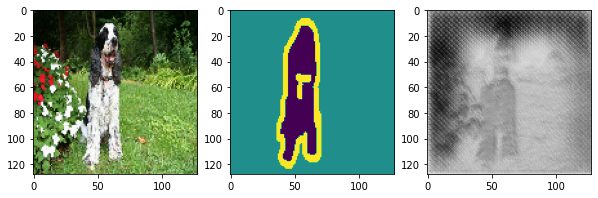

1/1 [==============================] - 0s 22ms/step


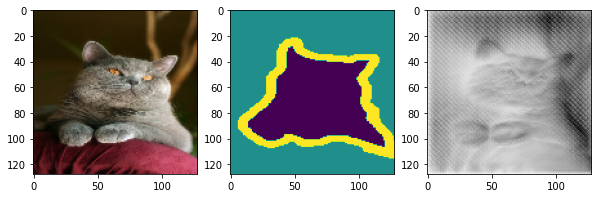

1/1 [==============================] - 0s 23ms/step


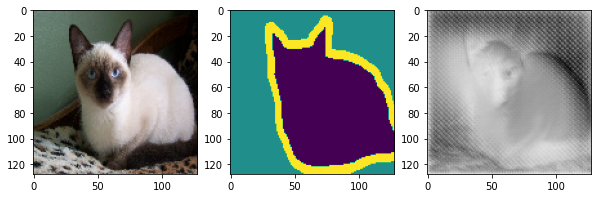

1/1 [==============================] - 0s 22ms/step


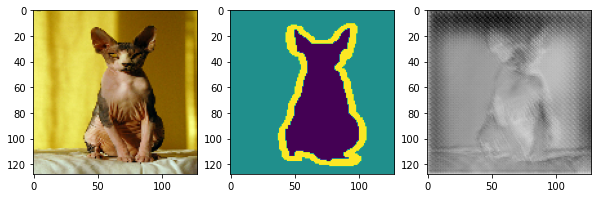

1/1 [==============================] - 0s 25ms/step


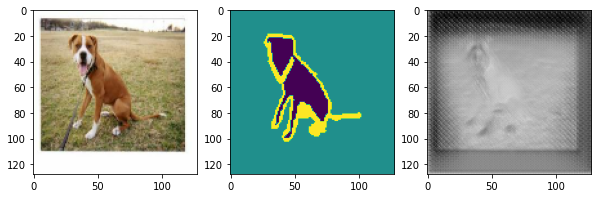

1/1 [==============================] - 0s 22ms/step


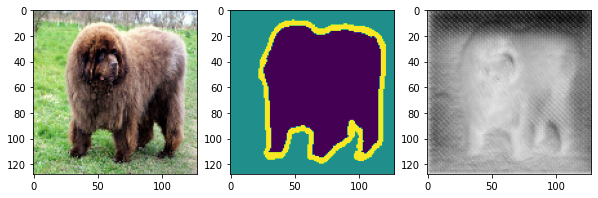

1/1 [==============================] - 0s 21ms/step


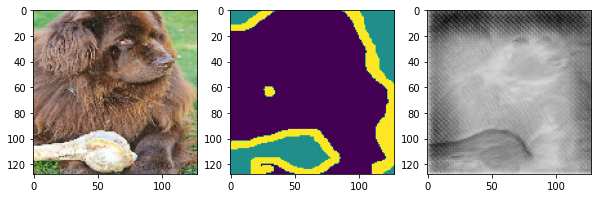

1/1 [==============================] - 0s 24ms/step


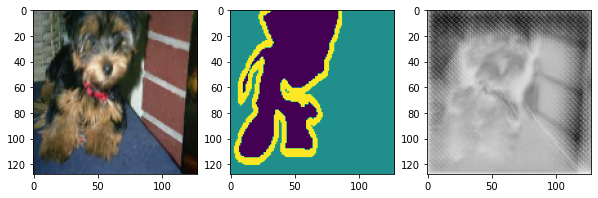

1/1 [==============================] - 0s 22ms/step


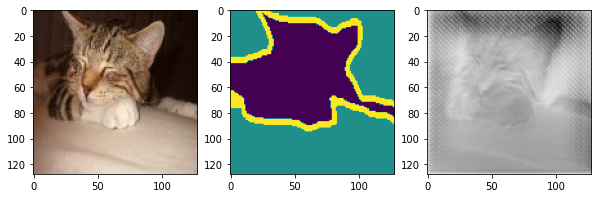

In [18]:
model=tf.keras.models.load_model('first_image_segementor.h5')
image=train_images.take(10)
for i in image:

    fig=plt.figure(1,figsize=(10,10))

    predictions=(np.array(model.predict(np.array(i[0]).reshape(1,128,128,3))).flatten()).reshape(128,128,1)

    for pos in range(len(i)):

      ax=fig.add_subplot(1,3,pos+1)
        
      ax.imshow(tf.keras.utils.array_to_img(i[pos]))

    ax=fig.add_subplot(1,3,pos+2)
      
    ax.imshow(tf.keras.utils.array_to_img(predictions),cmap='gray')
    plt.show()



In [19]:
stopppp

NameError: ignored

In [ ]:
#The cwll blobk below helps train the model further to see if there is still some possible convergence

In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

In [ ]:
model.save('first_image_segementor.h5')

In [ ]:
import pandas as pd
history_data=pd.DataFrame(history.history).plot(figsize=(10,5))